# Predict RUL with ≤10-cycle error from C-MAPSS data

##**Objective**: "Predict engine failure ≥30 cycles ahead with ≤10-cycle absolute error 90% of the time, deployed within 12 weeks."


In [ ]:
import os
from google.colab import drive
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from tensorflow.keras import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.losses import Huber
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Bidirectional

from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error


In [ ]:
if not os.path.ismount('/content/drive'):
    drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
train = pd.read_csv('/content/drive/MyDrive/besic_design_project/CMAPSSData/train_FD004.txt', sep='\\s+', header = None)
test = pd.read_csv('/content/drive/MyDrive/besic_design_project/CMAPSSData/test_FD004.txt',sep='\\s+', header = None)
rul = pd.read_csv('/content/drive/MyDrive/besic_design_project/CMAPSSData/RUL_FD004.txt', sep='\\s+', header = None)

Setting the columns name

In [ ]:
columns =   ['engine', 'time_in_cycle'] + \
            [f'op_setting_{i}' for i in range(1,4)]+\
            [f'sensor_{i}' for i in range(1,22)]
train.columns = columns
test.columns = columns
rul.columns = ['RUL']

In [ ]:
train

engine  time_in_cycle  op_setting_1  op_setting_2  op_setting_3  \
0           1              1       42.0049        0.8400         100.0   
1           1              2       20.0020        0.7002         100.0   
2           1              3       42.0038        0.8409         100.0   
3           1              4       42.0000        0.8400         100.0   
4           1              5       25.0063        0.6207          60.0   
...       ...            ...           ...           ...           ...   
61244     249            251        9.9998        0.2500         100.0   
61245     249            252        0.0028        0.0015         100.0   
61246     249            253        0.0029        0.0000         100.0   
61247     249            254       35.0046        0.8400         100.0   
61248     249            255       42.0030        0.8400         100.0   

       sensor_1  sensor_2  sensor_3  sensor_4  sensor_5  ...  sensor_12  \
0        445.00    549.68   1343.43   1112.93      3.91  ...     129.78   
1        491.19    606.07   1477.61   1237.50      9.35  ...     312.59   
2        445.00    548.95   1343.12   1117.05      3.91  ...     129.62   
3        445.00    548.70   1341.24   1118.03      3.91  ...     129.80   
4        462.54    536.10   1255.23   1033.59      7.05  ...     164.11   
...         ...       ...       ...       ...       ...  ...        ...   
61244    489.05    605.33   1516.36   1315.28     10.52  ...     380.16   
61245    518.67    643.42   1598.92   1426.77     14.62  ...     535.02   
61246    518.67    643.68   1607.72   1430.56     14.62  ...     535.41   
61247    449.44    555.77   1381.29   1148.18      5.48  ...     187.92   
61248    445.00    549.85   1369.75   1147.45      3.91  ...     134.32   

       sensor_13  sensor_14  sensor_15  sensor_16  sensor_17  sensor_18  \
0        2387.99    8074.83     9.3335       0.02        330       2212   
1        2387.73    8046.13     9.1913       0.02        361       2324   
2        2387.97    8066.62     9.4007       0.02        329       2212   
3        2388.02    8076.05     9.3369       0.02        328       2212   
4        2028.08    7865.80    10.8366       0.02        305       1915   
...          ...        ...        ...        ...        ...        ...   
61244    2388.73    8185.69     8.4541       0.03        372       2319   
61245    2388.46    8185.47     8.2221       0.03        396       2388   
61246    2388.48    8193.94     8.2525       0.03        395       2388   
61247    2388.83    8125.64     9.0515       0.02        337       2223   
61248    2388.66    8144.33     9.1207       0.02        333       2212   

       sensor_19  sensor_20  sensor_21  
0         100.00      10.62     6.3670  
1         100.00      24.37    14.6552  
2         100.00      10.48     6.4213  
3         100.00      10.54     6.4176  
4          84.93      14.03     8.6754  
...          ...        ...        ...  
61244     100.00      29.11    17.5234  
61245     100.00      39.38    23.7151  
61246     100.00      39.78    23.8270  
61247     100.00      15.26     9.0774  
61248     100.00      10.66     6.4341  

[61249 rows x 26 columns]

In [ ]:
test

engine  time_in_cycle  op_setting_1  op_setting_2  op_setting_3  \
0           1              1       20.0072        0.7000         100.0   
1           1              2       24.9984        0.6200          60.0   
2           1              3       42.0000        0.8420         100.0   
3           1              4       42.0035        0.8402         100.0   
4           1              5       35.0079        0.8400         100.0   
...       ...            ...           ...           ...           ...   
41209     248            277       41.9991        0.8401         100.0   
41210     248            278       20.0026        0.7005         100.0   
41211     248            279       34.9988        0.8413         100.0   
41212     248            280       20.0027        0.7000         100.0   
41213     248            281       35.0075        0.8402         100.0   

       sensor_1  sensor_2  sensor_3  sensor_4  sensor_5  ...  sensor_12  \
0        491.19    606.67   1481.04   1227.81      9.35  ...     313.03   
1        462.54    536.22   1256.17   1031.48      7.05  ...     163.61   
2        445.00    549.23   1340.13   1105.88      3.91  ...     129.98   
3        445.00    549.19   1339.70   1107.26      3.91  ...     129.48   
4        449.44    555.10   1353.04   1117.80      5.48  ...     181.82   
...         ...       ...       ...       ...       ...  ...        ...   
41209    445.00    550.30   1364.40   1129.17      3.91  ...     130.87   
41210    491.19    608.00   1494.75   1260.88      9.35  ...     314.51   
41211    449.44    555.92   1370.65   1130.97      5.48  ...     182.76   
41212    491.19    608.19   1489.11   1256.25      9.35  ...     314.17   
41213    449.44    556.40   1378.58   1140.70      5.48  ...     181.88   

       sensor_13  sensor_14  sensor_15  sensor_16  sensor_17  sensor_18  \
0        2387.78    8048.98     9.2229       0.02        362       2324   
1        2028.09    7863.46    10.8632       0.02        306       1915   
2        2387.95    8071.13     9.3960       0.02        328       2212   
3        2387.90    8078.89     9.3594       0.02        328       2212   
4        2387.87    8057.83     9.3030       0.02        333       2223   
...          ...        ...        ...        ...        ...        ...   
41209    2388.50    8112.61     9.4427       0.02        331       2212   
41210    2388.33    8086.83     9.2772       0.02        366       2324   
41211    2388.64    8100.84     9.3982       0.02        336       2223   
41212    2388.37    8085.24     9.2727       0.03        366       2324   
41213    2388.59    8098.17     9.3964       0.02        335       2223   

       sensor_19  sensor_20  sensor_21  
0         100.00      24.31    14.7007  
1          84.93      14.36     8.5748  
2         100.00      10.39     6.4365  
3         100.00      10.56     6.2367  
4         100.00      14.85     8.9326  
...          ...        ...        ...  
41209     100.00      10.53     6.2620  
41210     100.00      24.33    14.6486  
41211     100.00      14.69     8.8389  
41212     100.00      24.44    14.6887  
41213     100.00      14.72     8.8502  

[41214 rows x 26 columns]

In [ ]:
rul

RUL
0     22
1     39
2    107
3     75
4    149
..   ...
243   35
244  131
245  194
246  112
247   26

[248 rows x 1 columns]

adding rul column to the train dataset by calculaion (max cycle - current cycle)

In [ ]:
train['RUL'] = train.groupby('engine')['time_in_cycle'].transform('max') - train['time_in_cycle']


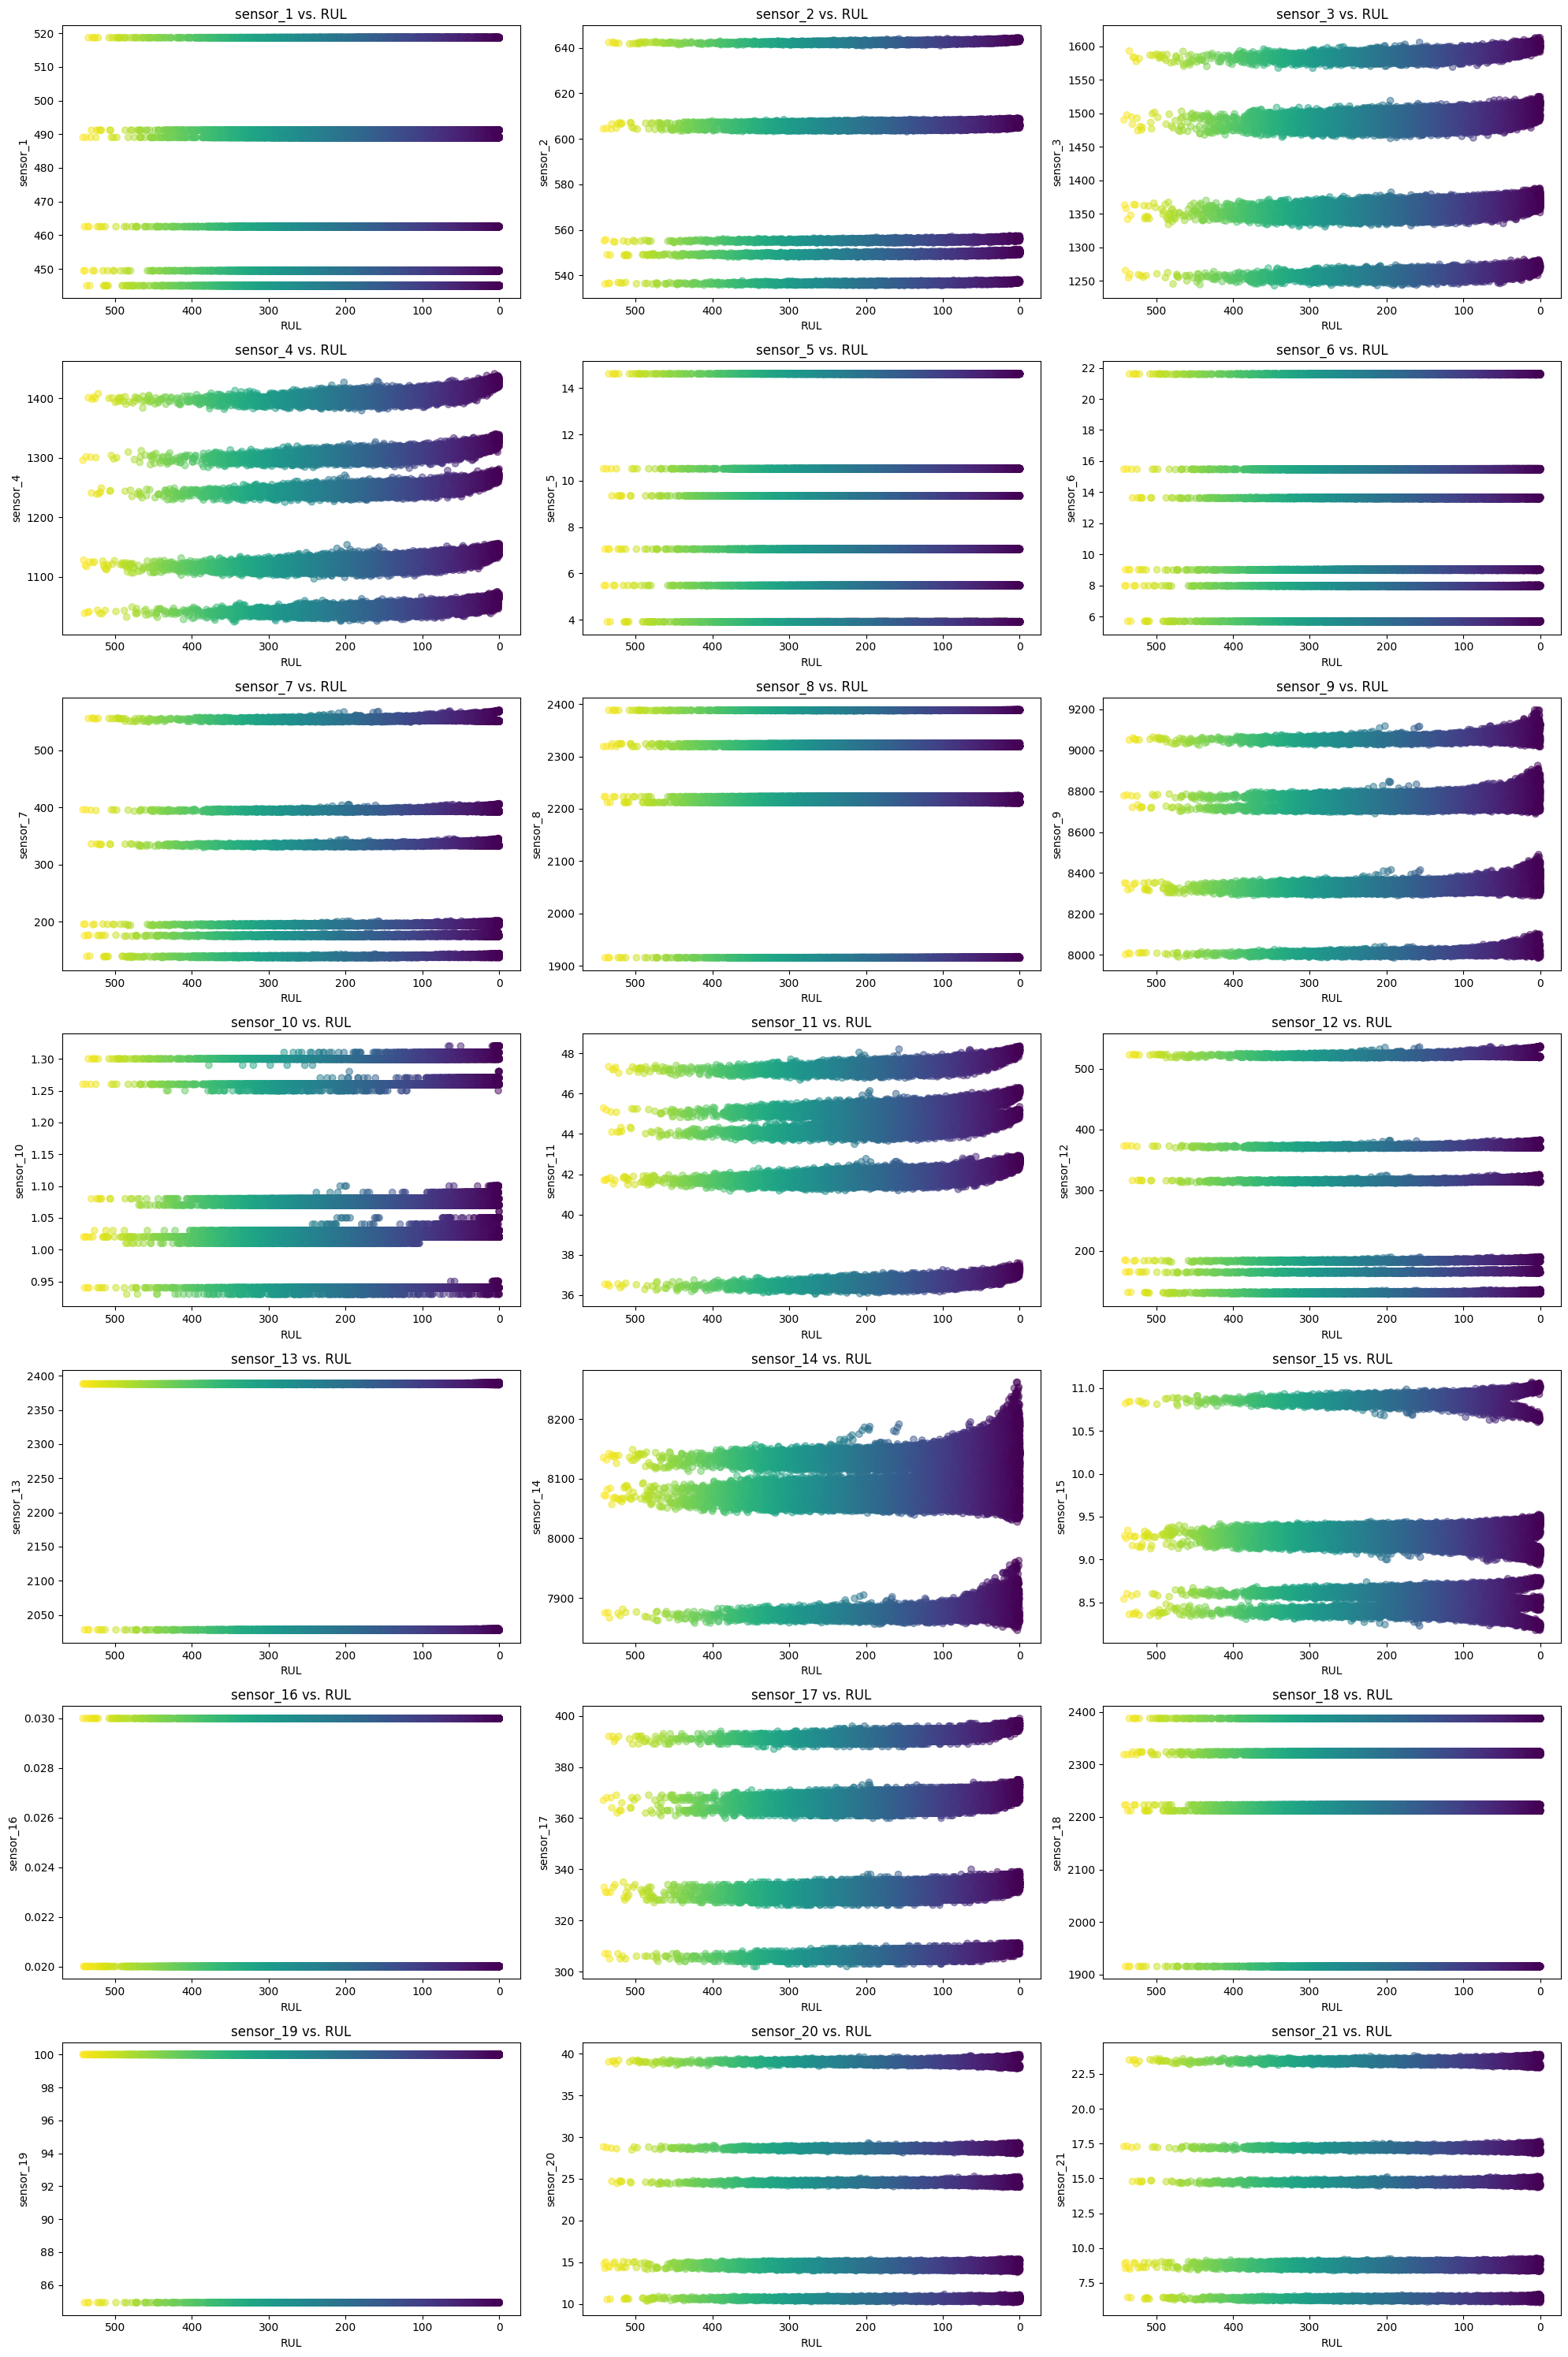

In [ ]:
plt.figure(figsize=(20, 30))

for i in range(1, 22):
    plt.subplot(7, 3, i)  # 7 rows × 3 columns grid
    sensor_col = f'sensor_{i}'
    plt.scatter(train['RUL'], train[sensor_col], c=train['RUL'], cmap='viridis', alpha=0.5)
    plt.xlabel('RUL')
    plt.ylabel(sensor_col)
    plt.title(f'{sensor_col} vs. RUL')
    plt.gca().invert_xaxis()

plt.tight_layout()
plt.show()

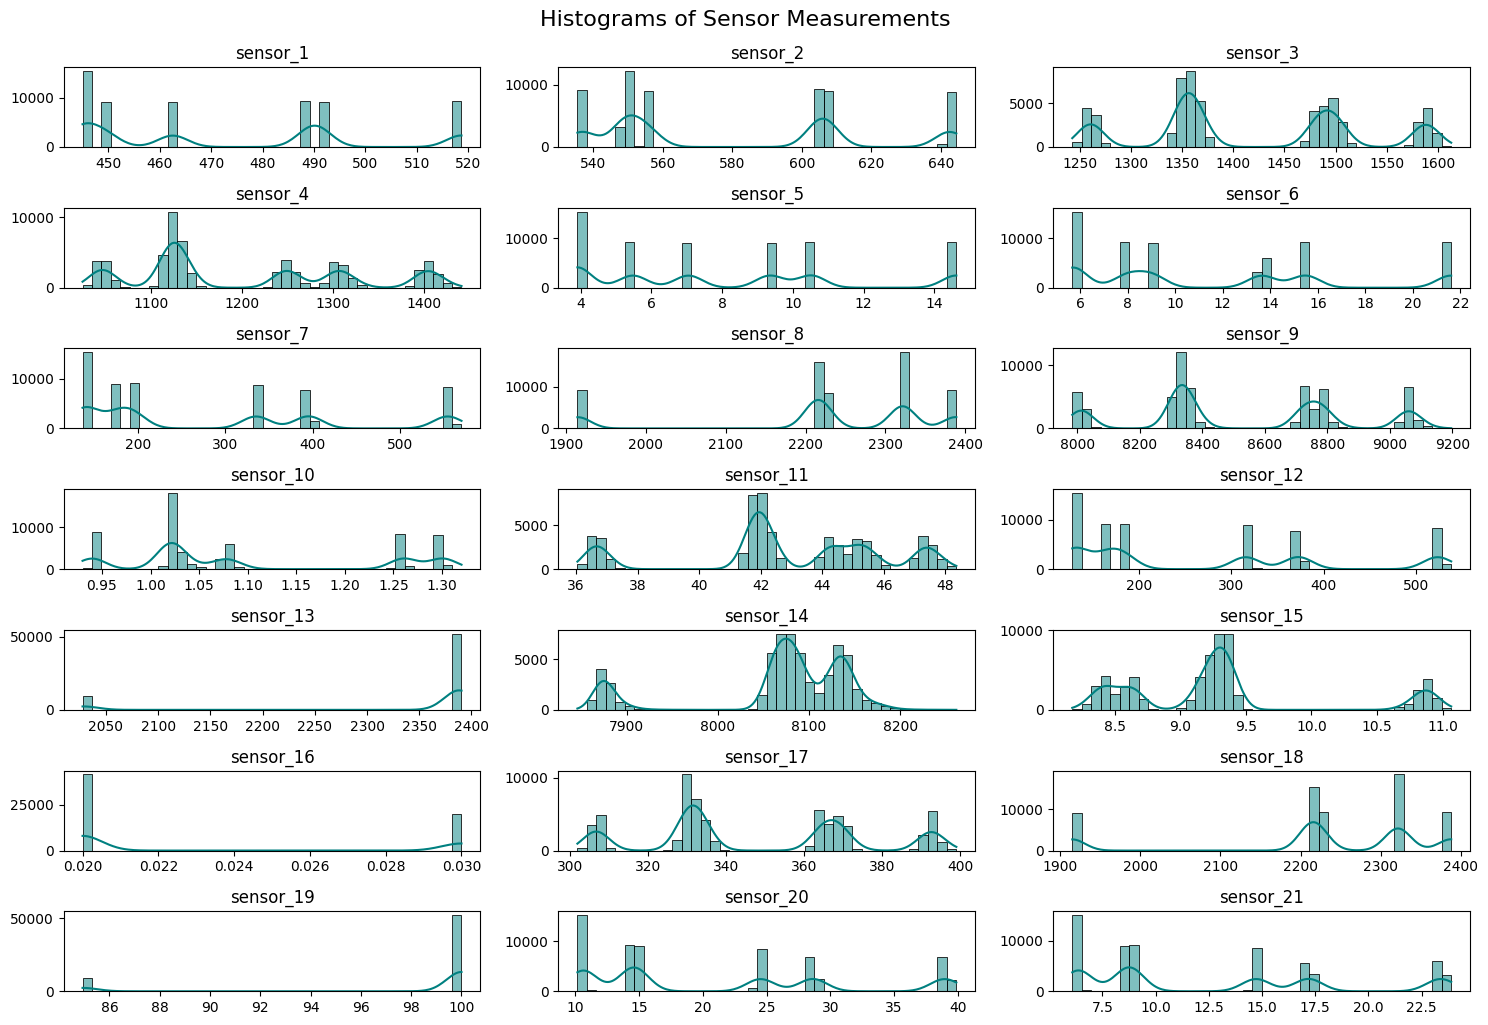

In [ ]:
sensor_cols = [f'sensor_{i}' for i in range(1, 22)]  # Pick top 5 for readability

plt.figure(figsize=(15, 10))
for i, col in enumerate(sensor_cols, 1):
    plt.subplot(7, 3, i)
    sns.histplot(train[col], bins=40, kde=True, color='teal')
    plt.title(f'{col}')
    plt.xlabel('')
    plt.ylabel('')

plt.tight_layout()
plt.suptitle('Histograms of Sensor Measurements', fontsize=16, y=1.02)
plt.show()

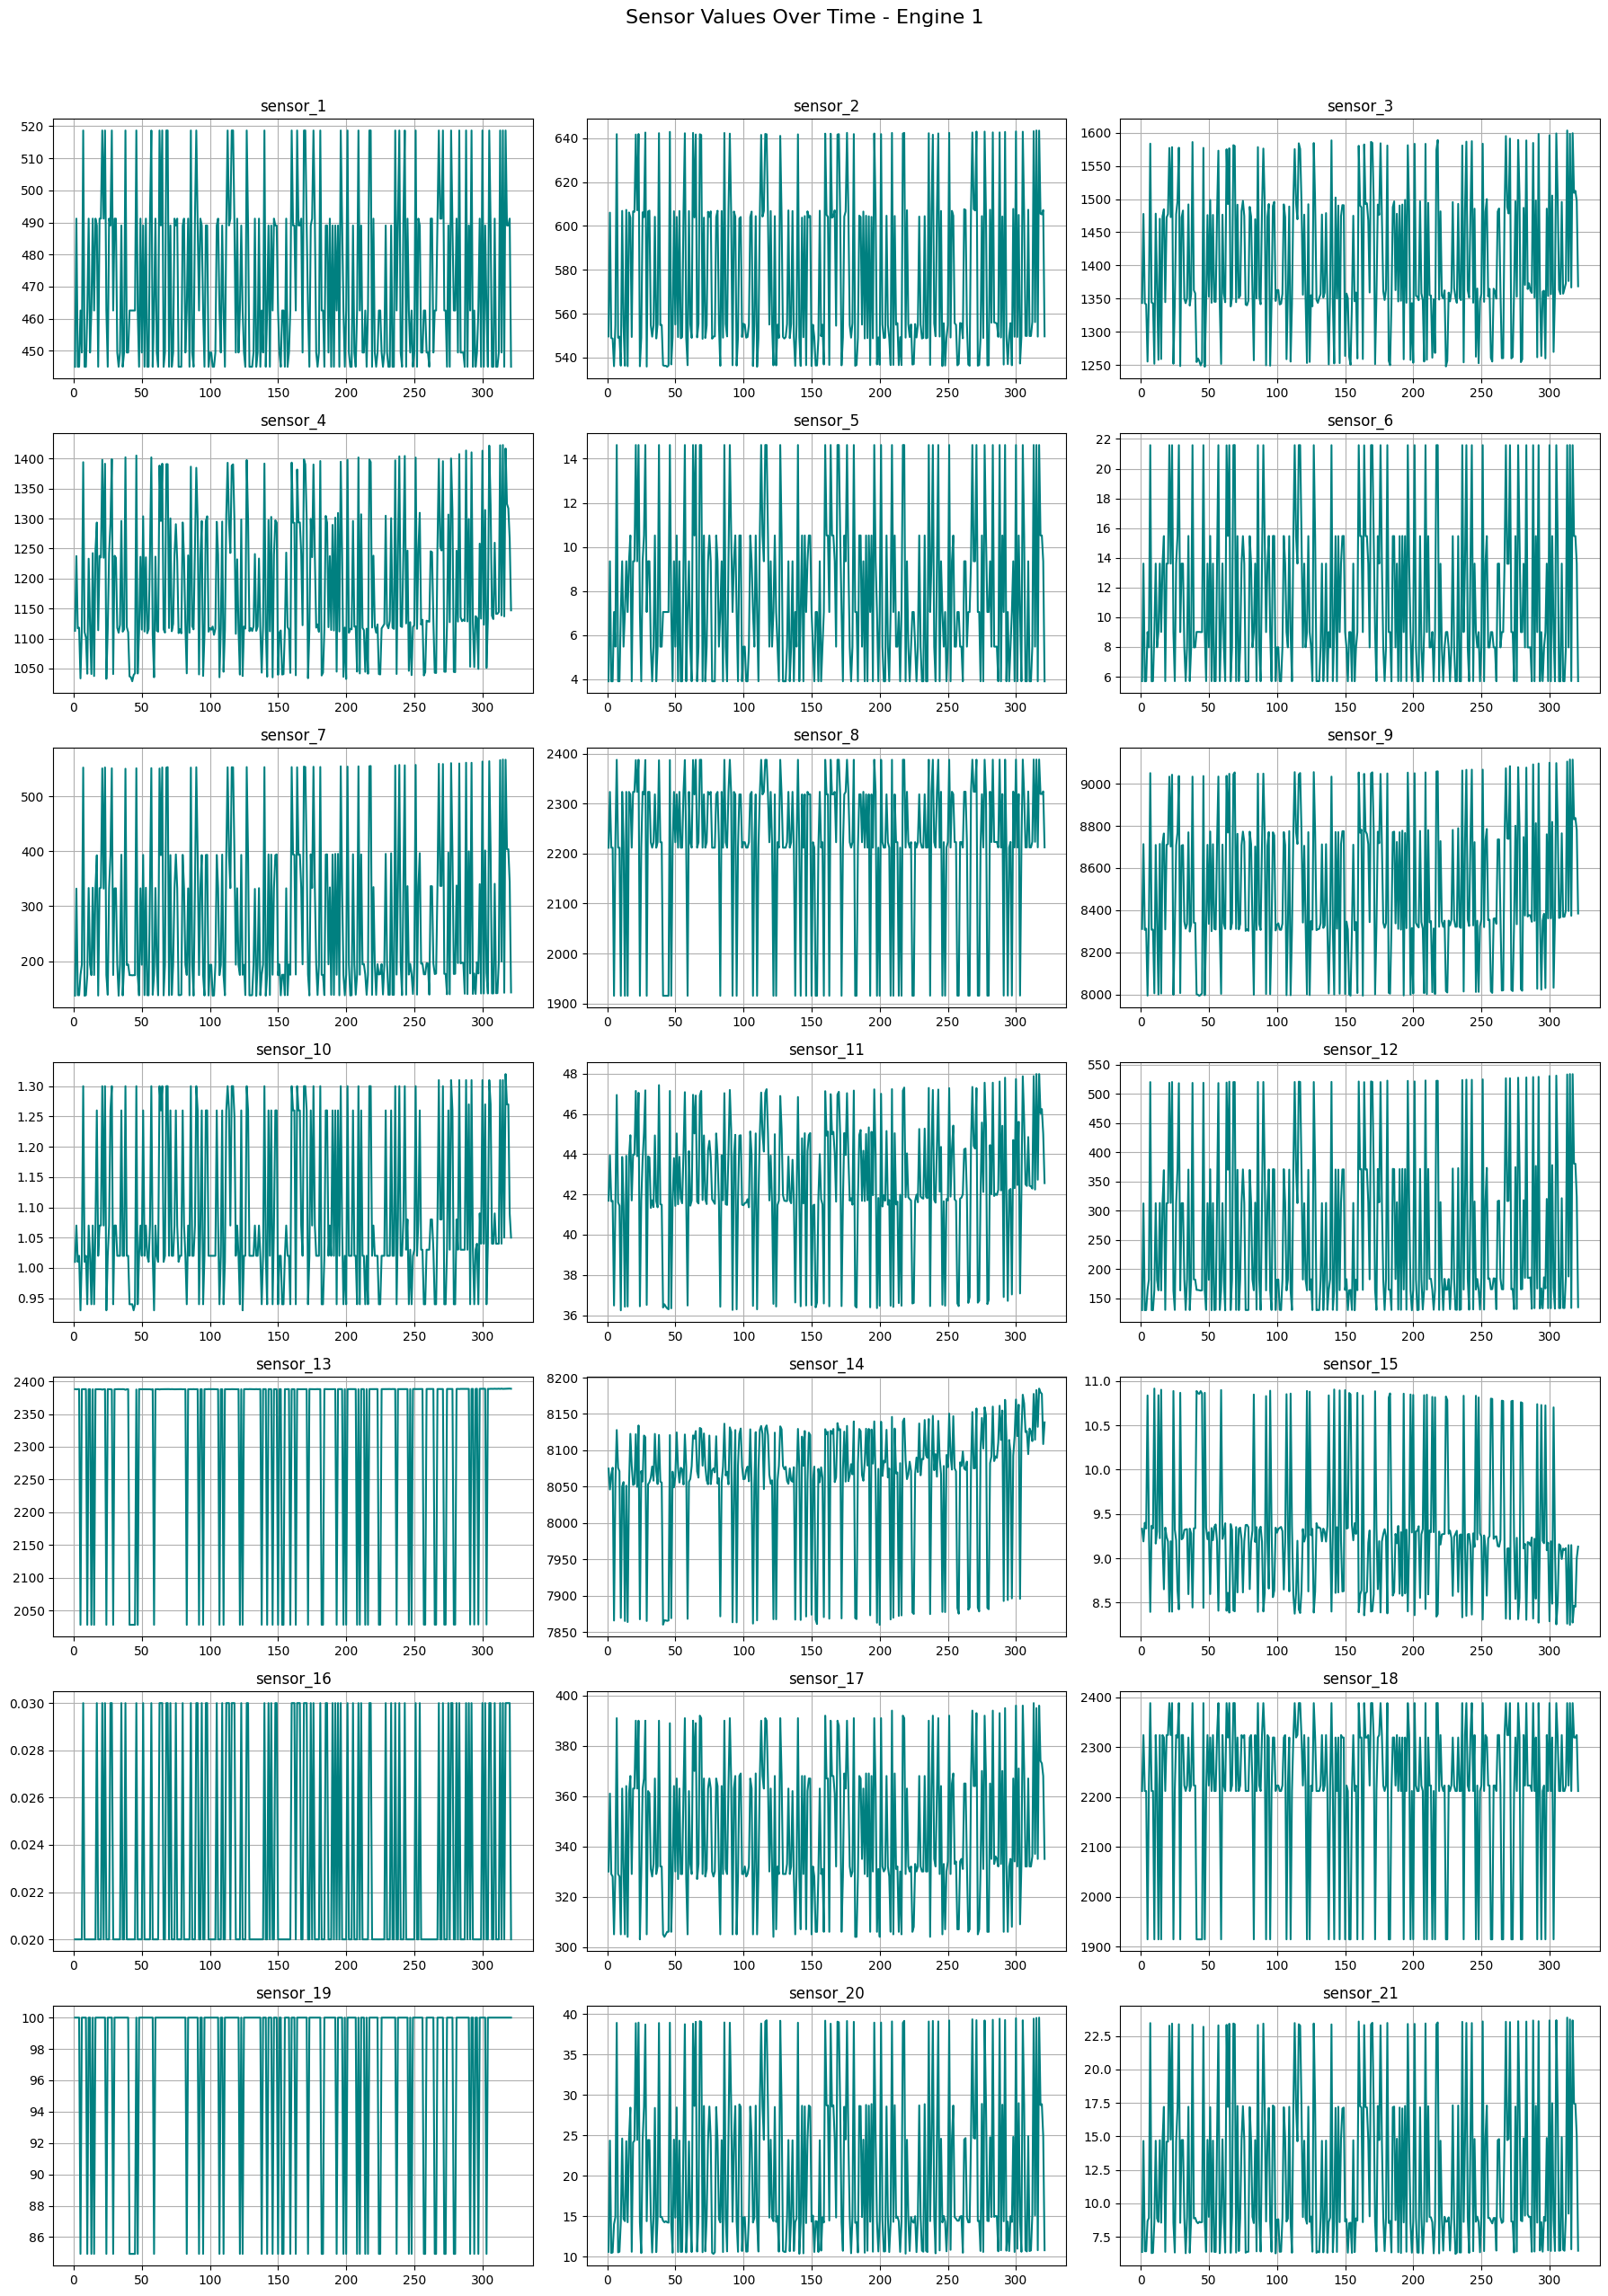

In [ ]:
# Select one engine (e.g., Engine 1)
engine_id = 1
engine = train[train['engine'] == engine_id]

# Create 21 subplots for 21 sensors
plt.figure(figsize=(18, 25))
for i in range(1, 22):
    plt.subplot(7, 3, i)
    sensor = f'sensor_{i}'
    sns.lineplot(data=engine, x='time_in_cycle', y=sensor, color='teal')
    plt.title(sensor)
    plt.xlabel('')
    plt.ylabel('')
    plt.grid(True)

plt.suptitle(f'Sensor Values Over Time - Engine {engine_id}', fontsize=16, y=1.02)
plt.tight_layout()
plt.show()

In [ ]:
train

engine  time_in_cycle  op_setting_1  op_setting_2  op_setting_3  \
0           1              1       42.0049        0.8400         100.0   
1           1              2       20.0020        0.7002         100.0   
2           1              3       42.0038        0.8409         100.0   
3           1              4       42.0000        0.8400         100.0   
4           1              5       25.0063        0.6207          60.0   
...       ...            ...           ...           ...           ...   
61244     249            251        9.9998        0.2500         100.0   
61245     249            252        0.0028        0.0015         100.0   
61246     249            253        0.0029        0.0000         100.0   
61247     249            254       35.0046        0.8400         100.0   
61248     249            255       42.0030        0.8400         100.0   

       sensor_1  sensor_2  sensor_3  sensor_4  sensor_5  ...  sensor_13  \
0        445.00    549.68   1343.43   1112.93      3.91  ...    2387.99   
1        491.19    606.07   1477.61   1237.50      9.35  ...    2387.73   
2        445.00    548.95   1343.12   1117.05      3.91  ...    2387.97   
3        445.00    548.70   1341.24   1118.03      3.91  ...    2388.02   
4        462.54    536.10   1255.23   1033.59      7.05  ...    2028.08   
...         ...       ...       ...       ...       ...  ...        ...   
61244    489.05    605.33   1516.36   1315.28     10.52  ...    2388.73   
61245    518.67    643.42   1598.92   1426.77     14.62  ...    2388.46   
61246    518.67    643.68   1607.72   1430.56     14.62  ...    2388.48   
61247    449.44    555.77   1381.29   1148.18      5.48  ...    2388.83   
61248    445.00    549.85   1369.75   1147.45      3.91  ...    2388.66   

       sensor_14  sensor_15  sensor_16  sensor_17  sensor_18  sensor_19  \
0        8074.83     9.3335       0.02        330       2212     100.00   
1        8046.13     9.1913       0.02        361       2324     100.00   
2        8066.62     9.4007       0.02        329       2212     100.00   
3        8076.05     9.3369       0.02        328       2212     100.00   
4        7865.80    10.8366       0.02        305       1915      84.93   
...          ...        ...        ...        ...        ...        ...   
61244    8185.69     8.4541       0.03        372       2319     100.00   
61245    8185.47     8.2221       0.03        396       2388     100.00   
61246    8193.94     8.2525       0.03        395       2388     100.00   
61247    8125.64     9.0515       0.02        337       2223     100.00   
61248    8144.33     9.1207       0.02        333       2212     100.00   

       sensor_20  sensor_21  RUL  
0          10.62     6.3670  320  
1          24.37    14.6552  319  
2          10.48     6.4213  318  
3          10.54     6.4176  317  
4          14.03     8.6754  316  
...          ...        ...  ...  
61244      29.11    17.5234    4  
61245      39.38    23.7151    3  
61246      39.78    23.8270    2  
61247      15.26     9.0774    1  
61248      10.66     6.4341    0  

[61249 rows x 27 columns]

### 🔧 Selected Sensors for FD004 (C-MAPSS)

To improve model accuracy and reduce noise, we selected a subset of meaningful sensors based on NASA documentation and known degradation patterns in FD004.

| Sensor Index | Sensor Name                     | Reason for Inclusion                      |
|--------------|----------------------------------|-------------------------------------------|
| `sensor_2`   | Total temperature at LPC outlet | Tracks heat buildup under load            |
| `sensor_3`   | Total pressure at HPC outlet    | Indicates pressure drops and wear         |
| `sensor_4`   | Fan speed                       | Reflects RPM degradation                  |
| `sensor_7`   | Bypass-duct pressure            | Common degradation indicator              |
| `sensor_11`  | Fuel flow                       | Changes with efficiency loss              |
| `sensor_12`  | Thrust                          | Often decreases before failure            |
| `sensor_15`  | HPT coolant supply temperature  | Detects overheating in critical turbine   |

These sensors were used to train the LSTM model to focus on the most relevant operational signals that impact engine health over time.


In [ ]:
selected_sensors = ['sensor_2', 'sensor_3', 'sensor_4', 'sensor_7', 'sensor_11', 'sensor_12', 'sensor_15']
selected_sensors

['sensor_2',
 'sensor_3',
 'sensor_4',
 'sensor_7',
 'sensor_11',
 'sensor_12',
 'sensor_15']

In [ ]:
scaler = MinMaxScaler()
train[selected_sensors] = scaler.fit_transform(train[selected_sensors])
test[selected_sensors] = scaler.transform(test[selected_sensors])

In [ ]:
train

engine  time_in_cycle  op_setting_1  op_setting_2  op_setting_3  \
0           1              1       42.0049        0.8400         100.0   
1           1              2       20.0020        0.7002         100.0   
2           1              3       42.0038        0.8409         100.0   
3           1              4       42.0000        0.8400         100.0   
4           1              5       25.0063        0.6207          60.0   
...       ...            ...           ...           ...           ...   
61244     249            251        9.9998        0.2500         100.0   
61245     249            252        0.0028        0.0015         100.0   
61246     249            253        0.0029        0.0000         100.0   
61247     249            254       35.0046        0.8400         100.0   
61248     249            255       42.0030        0.8400         100.0   

       sensor_1  sensor_2  sensor_3  sensor_4  sensor_5  ...  sensor_13  \
0        445.00  0.130347  0.272082  0.212586      3.91  ...    2387.99   
1        491.19  0.647971  0.634407  0.511781      9.35  ...    2387.73   
2        445.00  0.123646  0.271245  0.222481      3.91  ...    2387.97   
3        445.00  0.121351  0.266168  0.224835      3.91  ...    2388.02   
4        462.54  0.005691  0.033916  0.022025      7.05  ...    2028.08   
...         ...       ...       ...       ...       ...  ...        ...   
61244    489.05  0.641179  0.739044  0.698595     10.52  ...    2388.73   
61245    518.67  0.990821  0.961980  0.966374     14.62  ...    2388.46   
61246    518.67  0.993207  0.985742  0.975477     14.62  ...    2388.48   
61247    449.44  0.186249  0.374315  0.297250      5.48  ...    2388.83   
61248    445.00  0.131907  0.343153  0.295497      3.91  ...    2388.66   

       sensor_14  sensor_15  sensor_16  sensor_17  sensor_18  sensor_19  \
0        8074.83   0.400540       0.02        330       2212     100.00   
1        8046.13   0.351346       0.02        361       2324     100.00   
2        8066.62   0.423787       0.02        329       2212     100.00   
3        8076.05   0.401716       0.02        328       2212     100.00   
4        7865.80   0.920536       0.02        305       1915      84.93   
...          ...        ...        ...        ...        ...        ...   
61244    8185.69   0.096312       0.03        372       2319     100.00   
61245    8185.47   0.016052       0.03        396       2388     100.00   
61246    8193.94   0.026569       0.03        395       2388     100.00   
61247    8125.64   0.302982       0.02        337       2223     100.00   
61248    8144.33   0.326922       0.02        333       2212     100.00   

       sensor_20  sensor_21  RUL  
0          10.62     6.3670  320  
1          24.37    14.6552  319  
2          10.48     6.4213  318  
3          10.54     6.4176  317  
4          14.03     8.6754  316  
...          ...        ...  ...  
61244      29.11    17.5234    4  
61245      39.38    23.7151    3  
61246      39.78    23.8270    2  
61247      15.26     9.0774    1  
61248      10.66     6.4341    0  

[61249 rows x 27 columns]

In [ ]:
test

engine  time_in_cycle  op_setting_1  op_setting_2  op_setting_3  \
0           1              1       20.0072        0.7000         100.0   
1           1              2       24.9984        0.6200          60.0   
2           1              3       42.0000        0.8420         100.0   
3           1              4       42.0035        0.8402         100.0   
4           1              5       35.0079        0.8400         100.0   
...       ...            ...           ...           ...           ...   
41209     248            277       41.9991        0.8401         100.0   
41210     248            278       20.0026        0.7005         100.0   
41211     248            279       34.9988        0.8413         100.0   
41212     248            280       20.0027        0.7000         100.0   
41213     248            281       35.0075        0.8402         100.0   

       sensor_1  sensor_2  sensor_3  sensor_4  sensor_5  ...  sensor_12  \
0        491.19  0.653479  0.643669  0.488507      9.35  ...   0.451439   
1        462.54  0.006793  0.036454  0.016957      7.05  ...   0.086270   
2        445.00  0.126216  0.263171  0.195653      3.91  ...   0.004081   
3        445.00  0.125849  0.262010  0.198967      3.91  ...   0.002859   
4        449.44  0.180099  0.298031  0.224282      5.48  ...   0.130774   
...         ...       ...       ...       ...       ...  ...        ...   
41209    445.00  0.136038  0.328707  0.251591      3.91  ...   0.006256   
41210    491.19  0.665688  0.680690  0.567936      9.35  ...   0.455056   
41211    449.44  0.187626  0.345584  0.255914      5.48  ...   0.133071   
41212    491.19  0.667432  0.665461  0.556815      9.35  ...   0.454226   
41213    449.44  0.192032  0.366997  0.279284      5.48  ...   0.130920   

       sensor_13  sensor_14  sensor_15  sensor_16  sensor_17  sensor_18  \
0        2387.78    8048.98   0.362278       0.02        362       2324   
1        2028.09    7863.46   0.929738       0.02        306       1915   
2        2387.95    8071.13   0.422161       0.02        328       2212   
3        2387.90    8078.89   0.409500       0.02        328       2212   
4        2387.87    8057.83   0.389988       0.02        333       2223   
...          ...        ...        ...        ...        ...        ...   
41209    2388.50    8112.61   0.438317       0.02        331       2212   
41210    2388.33    8086.83   0.381063       0.02        366       2324   
41211    2388.64    8100.84   0.422923       0.02        336       2223   
41212    2388.37    8085.24   0.379506       0.03        366       2324   
41213    2388.59    8098.17   0.422300       0.02        335       2223   

       sensor_19  sensor_20  sensor_21  
0         100.00      24.31    14.7007  
1          84.93      14.36     8.5748  
2         100.00      10.39     6.4365  
3         100.00      10.56     6.2367  
4         100.00      14.85     8.9326  
...          ...        ...        ...  
41209     100.00      10.53     6.2620  
41210     100.00      24.33    14.6486  
41211     100.00      14.69     8.8389  
41212     100.00      24.44    14.6887  
41213     100.00      14.72     8.8502  

[41214 rows x 26 columns]

In [ ]:
x_train = train[selected_sensors]
y_train = train.RUL

In [ ]:
x_train

sensor_2  sensor_3  sensor_4  sensor_7  sensor_11  sensor_12  sensor_15
0      0.130347  0.272082  0.212586  0.002738   0.458604   0.003593   0.400540
1      0.647971  0.634407  0.511781  0.450787   0.641234   0.450364   0.351346
2      0.123646  0.271245  0.222481  0.004625   0.456169   0.003202   0.423787
3      0.121351  0.266168  0.224835  0.004164   0.457792   0.003641   0.401716
4      0.005691  0.033916  0.022025  0.088924   0.035714   0.087492   0.920536
...         ...       ...       ...       ...        ...        ...        ...
61244  0.641179  0.739044  0.698595  0.617569   0.814935   0.615499   0.096312
61245  0.990821  0.961980  0.966374  0.992592   0.974026   0.993964   0.016052
61246  0.993207  0.985742  0.975477  0.995928   0.990260   0.994917   0.026569
61247  0.186249  0.374315  0.297250  0.146696   0.526786   0.145682   0.302982
61248  0.131907  0.343153  0.295497  0.014495   0.532468   0.014688   0.326922

[61249 rows x 7 columns]

In [ ]:
model_random_forest = RandomForestRegressor(n_jobs =-1)

In [ ]:
model_random_forest.fit(x_train, y_train)

RandomForestRegressor(n_jobs=-1)

In [ ]:
model_linear_regrassion = LinearRegression()
model_linear_regrassion.fit(x_train, y_train)

LinearRegression()

In [ ]:
model_xgboost = XGBRegressor()
model_xgboost.fit(x_train,y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [ ]:
def gen_sequence(data, window_size):
    seq_x, seq_y = [], []
    for engine_id in data['engine'].unique():
        engine_data = data[data['engine'] == engine_id]
        for i in range(len(engine_data) - window_size + 1):
            seq = engine_data.iloc[i:i + window_size]
            seq_x.append(seq[selected_sensors].values)
            seq_y.append(seq['RUL'].values[-1])
    return np.array(seq_x), np.array(seq_y)

window_size = 30
x_train2, y_train2 = gen_sequence(train, window_size)

In [ ]:

model_lstm = Sequential([
    Bidirectional(LSTM(128, return_sequences=True, input_shape=(window_size, len(selected_sensors)))),
    Bidirectional(LSTM(64)),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dense(1)
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [ ]:
model_lstm.compile(
    loss=Huber(),
    optimizer=RMSprop(learning_rate=0.001),
     metrics=['mean_absolute_error']
)


In [ ]:
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5,        # stop after 5 non-improving epochs
    restore_best_weights=True
)
history = model_lstm.fit(
    x_train2, y_train2,
    epochs=50,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stop]
)

Epoch 1/50
1351/1351 ━━━━━━━━━━━━━━━━━━━━ 22s 12ms/step - loss: 72.0636 - mean_absolute_error: 72.5620 - val_loss: 63.0264 - val_mean_absolute_error: 63.5251
Epoch 2/50
1351/1351 ━━━━━━━━━━━━━━━━━━━━ 18s 12ms/step - loss: 67.2130 - mean_absolute_error: 67.7115 - val_loss: 63.0130 - val_mean_absolute_error: 63.5119
Epoch 3/50
1351/1351 ━━━━━━━━━━━━━━━━━━━━ 20s 12ms/step - loss: 66.7288 - mean_absolute_error: 67.2272 - val_loss: 63.8991 - val_mean_absolute_error: 64.3978
Epoch 4/50
1351/1351 ━━━━━━━━━━━━━━━━━━━━ 21s 12ms/step - loss: 63.5256 - mean_absolute_error: 64.0238 - val_loss: 58.2374 - val_mean_absolute_error: 58.7350
Epoch 5/50
1351/1351 ━━━━━━━━━━━━━━━━━━━━ 20s 12ms/step - loss: 54.4579 - mean_absolute_error: 54.9558 - val_loss: 63.8939 - val_mean_absolute_error: 64.3929
Epoch 6/50
1351/1351 ━━━━━━━━━━━━━━━━━━━━ 15s 11ms/step - loss: 52.3914 - mean_absolute_error: 52.8889 - val_loss: 49.4987 - val_mean_absolute_error: 49.9970
Epoch 7/50
1351/1351 ━━━━━━━━━━━━━━━━━━━━ 22s 12ms/s

In [ ]:
def get_last_sequence(data, window_size, selected_sensors):
    seqs = []
    for engine_id in data['engine'].unique():
        engine_data = data[data['engine'] == engine_id].tail(window_size)
        if len(engine_data) < window_size:
            pad_len = window_size - len(engine_data)
            pad = np.zeros((pad_len, len(selected_sensors)), dtype=np.float32)  # pad zeros at front
            seq = np.vstack((pad, engine_data[selected_sensors].values))
        else:
            seq = engine_data[selected_sensors].values
        seqs.append(seq)
    return np.array(seqs, dtype=np.float32)


In [ ]:
last_test = test.groupby('engine').tail(1)
x_test = last_test[selected_sensors]
x_test_lstm = get_last_sequence(test, window_size, selected_sensors)
y_pred_random_forest = model_random_forest.predict(x_test)
y_pred_linear_regrassion = model_linear_regrassion.predict(x_test)
y_pred_xgboost = model_xgboost.predict(x_test)
y_pred_lstm = model_lstm.predict(x_test_lstm).flatten()
y_true = rul.RUL.values

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step


In [ ]:
x_test

sensor_2  sensor_3  sensor_4  sensor_7  sensor_11  sensor_12  sensor_15
229    0.020011  0.058434  0.052816  0.092927   0.067370   0.092575   0.894555
382    0.132917  0.300759  0.262111  0.006580   0.507305   0.004546   0.420951
523    0.128419  0.265682  0.226924  0.007109   0.469156   0.005914   0.388051
731    0.005324  0.029217  0.033890  0.090788   0.043019   0.089447   0.921573
782    0.017257  0.056517  0.067491  0.090558   0.086851   0.089545   0.945721
...         ...       ...       ...       ...        ...        ...        ...
40746  0.665137  0.663138  0.555062  0.456815   0.701299   0.455887   0.373625
40809  0.652928  0.644857  0.513702  0.461232   0.665584   0.458673   0.334325
40838  0.654856  0.648989  0.520956  0.457137   0.646916   0.456792   0.346329
40932  0.013126  0.051306  0.067035  0.091271   0.077922   0.088690   0.953954
41213  0.192032  0.366997  0.279284  0.133651   0.490260   0.130920   0.422300

[248 rows x 7 columns]

In [ ]:
model_linear_regrassion.score(x_test, y_true)


-0.4160333391989819

In [ ]:
model_random_forest.score(x_test, y_true)

0.17193996456794858

In [ ]:
model_xgboost.score(x_test, y_true)

0.22997325658798218

In [ ]:
model_lstm.evaluate(x_test_lstm, y_true)

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 29.5540 - mean_absolute_error: 30.0493 


[29.050607681274414, 29.54473114013672]

In [ ]:
mae_random_forest = mean_absolute_error(y_true, y_pred_random_forest)
rmse_random_forest = np.sqrt(mean_squared_error(y_true, y_pred_random_forest))

mae_linear_regrassion = mean_absolute_error(y_true, y_pred_linear_regrassion)
rmse_linear_regrassion = np.sqrt(mean_squared_error(y_true, y_pred_linear_regrassion))

mae_xgboost = mean_absolute_error(y_true, y_pred_xgboost)
rmse_xgboost = np.sqrt(mean_squared_error(y_true, y_pred_xgboost))

mae_lstm = mean_absolute_error(y_true, y_pred_lstm)
rmse_lstm = np.sqrt(mean_squared_error(y_true, y_pred_lstm))

In [ ]:
print(f'MAE of random forest = {mae_random_forest:.2f}')
print(f'MAE of Linear Rigrassion = {mae_linear_regrassion:.2f}')
print(f'MAE of XGBoost = {mae_xgboost:.2f}')
print(f'MAE OF LSTM = {mae_lstm:.2f}\n')
print(f'RMSE of random forest = {rmse_random_forest:.2f}')
print(f'RMSE of Linear Regrssion = {rmse_linear_regrassion:.2f}')
print(f'RMSE of XGBoost = {rmse_xgboost:.2f}')
print(f'RMSE of LSTM = {rmse_lstm:.2f}\n')
print(f'frist 5 True RULs = {y_true[:5]}\n')
print(f'first 5 predicted RULS using RANDOM FOREST = {np.round(y_pred_random_forest[:5], 0)}')
print(f'first 5 predictes RULS using Linear Regrassion = {np.round(y_pred_linear_regrassion[:5], 0)}')
print(f'first 5 predicted RULS using XGBoost = {np.round(y_pred_xgboost[:5], 0)}')
print(f'first 5 predicted RULS using LSMT = {np.round(y_pred_lstm[:5], 0)}')

MAE of random forest = 38.10
MAE of Linear Rigrassion = 51.95
MAE of XGBoost = 36.71
MAE OF LSTM = 29.54

RMSE of random forest = 49.62
RMSE of Linear Regrssion = 64.88
RMSE of XGBoost = 47.85
RMSE of LSTM = 37.91

frist 5 True RULs = [ 22  39 107  75 149]

first 5 predicted RULS using RANDOM FOREST = [ 97.  63. 188. 224.  98.]
first 5 predictes RULS using Linear Regrassion = [158.  75. 187. 172.  83.]
first 5 predicted RULS using XGBoost = [ 56.  65. 178. 202.  84.]
first 5 predicted RULS using LSMT = [ 77.  40. 141. 156.  37.]


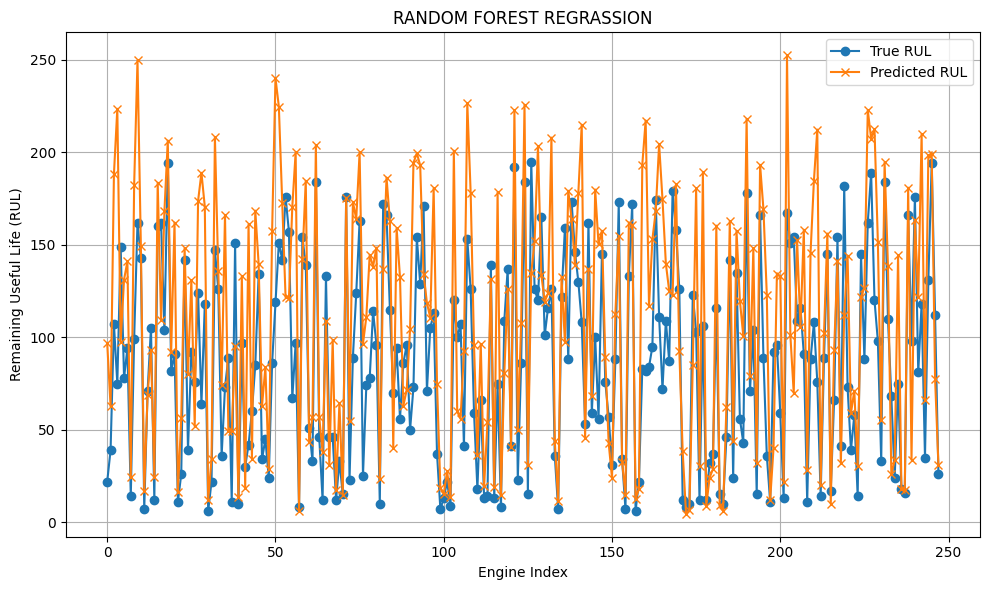

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(y_true, label='True RUL', marker='o')
plt.plot(y_pred_random_forest, label='Predicted RUL', marker='x')
plt.xlabel('Engine Index')
plt.ylabel('Remaining Useful Life (RUL)')
plt.title('RANDOM FOREST REGRASSION')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

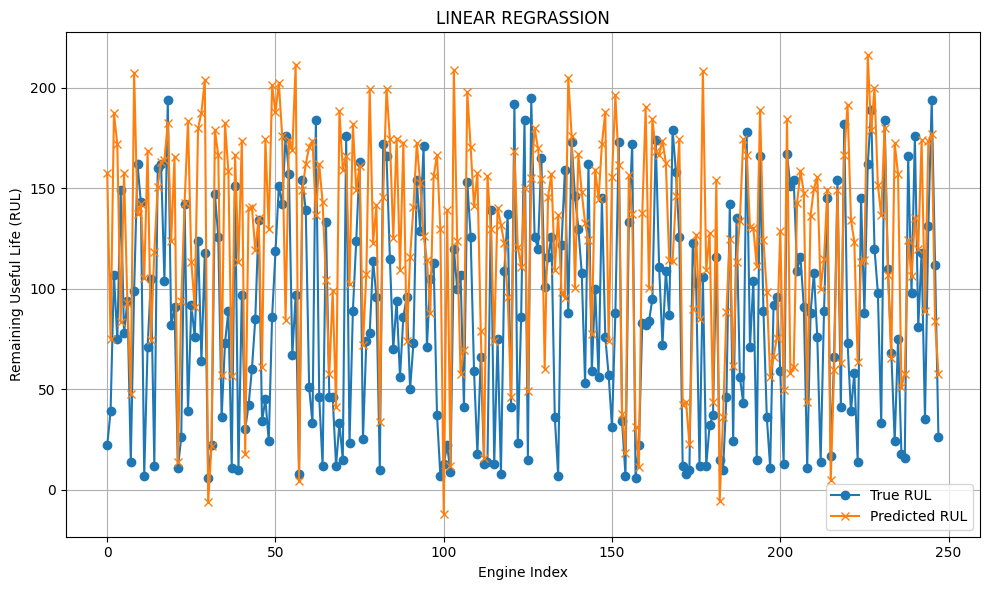

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(y_true, label='True RUL', marker='o')
plt.plot(y_pred_linear_regrassion, label='Predicted RUL', marker='x')
plt.xlabel('Engine Index')
plt.ylabel('Remaining Useful Life (RUL)')
plt.title('LINEAR REGRASSION')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

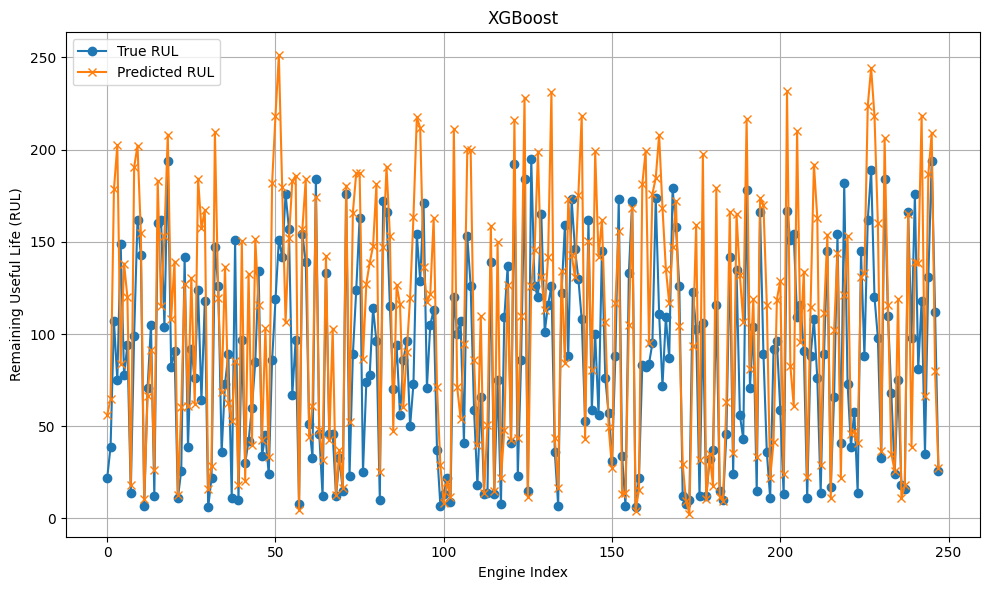

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(y_true, label='True RUL', marker='o')
plt.plot(y_pred_xgboost, label='Predicted RUL', marker='x')
plt.xlabel('Engine Index')
plt.ylabel('Remaining Useful Life (RUL)')
plt.title('XGBoost')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

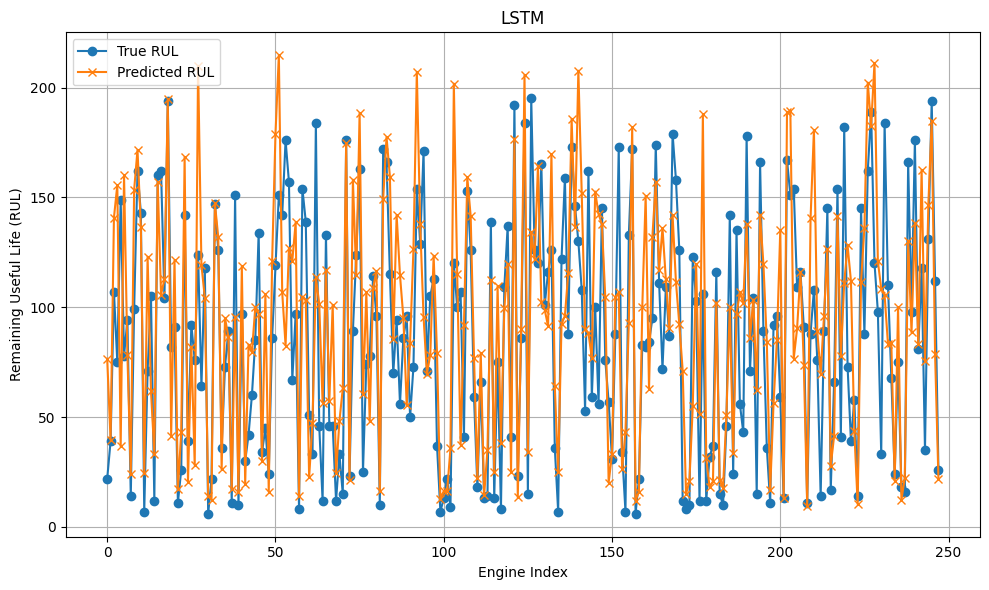

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(y_true, label='True RUL', marker='o')
plt.plot(y_pred_lstm, label='Predicted RUL', marker='x')
plt.xlabel('Engine Index')
plt.ylabel('Remaining Useful Life (RUL)')
plt.title('LSTM')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

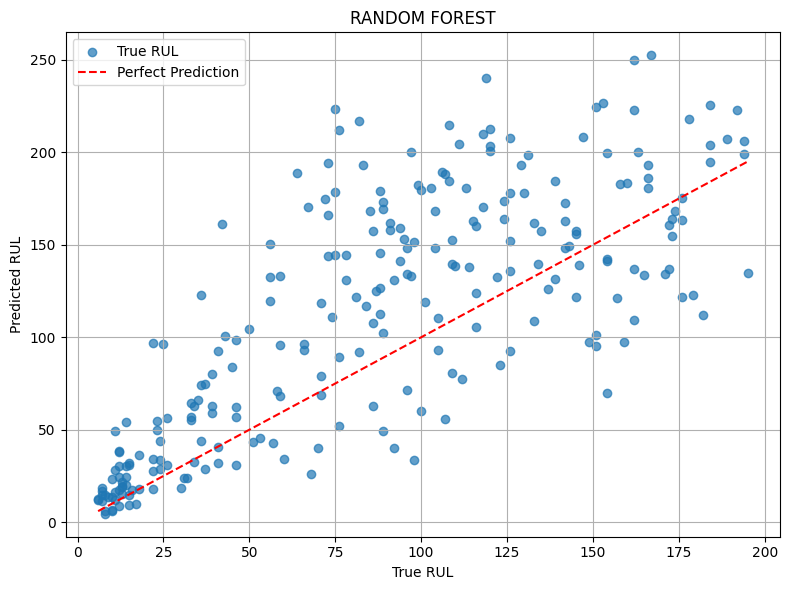

In [ ]:
plt.figure(figsize=(8, 6))
plt.scatter(y_true, y_pred_random_forest, alpha=0.7, label = 'True RUL')
plt.plot([min(y_true), max(y_true)], [min(y_true), max(y_true)], 'r--', label='Perfect Prediction')
plt.xlabel('True RUL')
plt.ylabel('Predicted RUL')
plt.title('RANDOM FOREST')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

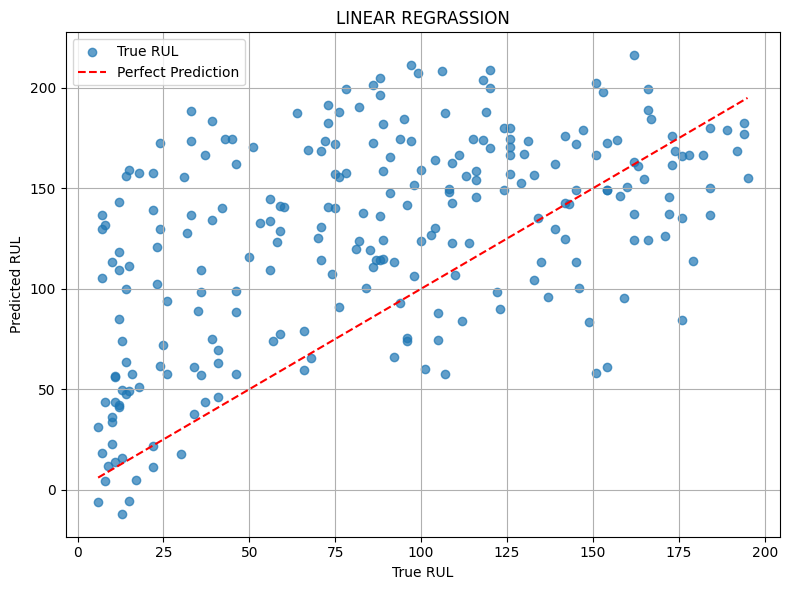

In [ ]:
plt.figure(figsize=(8, 6))
plt.scatter(y_true, y_pred_linear_regrassion, alpha=0.7, label = 'True RUL')
plt.plot([min(y_true), max(y_true)], [min(y_true), max(y_true)], 'r--', label='Perfect Prediction')
plt.xlabel('True RUL')
plt.ylabel('Predicted RUL')
plt.title('LINEAR REGRASSION')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

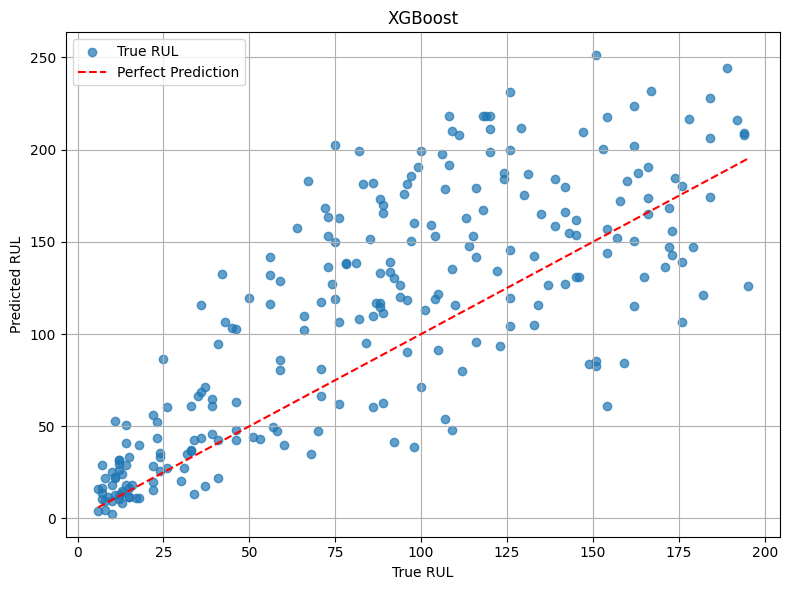

In [ ]:
plt.figure(figsize=(8, 6))
plt.scatter(y_true, y_pred_xgboost, alpha=0.7, label = 'True RUL')
plt.plot([min(y_true), max(y_true)], [min(y_true), max(y_true)], 'r--', label='Perfect Prediction')
plt.xlabel('True RUL')
plt.ylabel('Predicted RUL')
plt.title('XGBoost')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

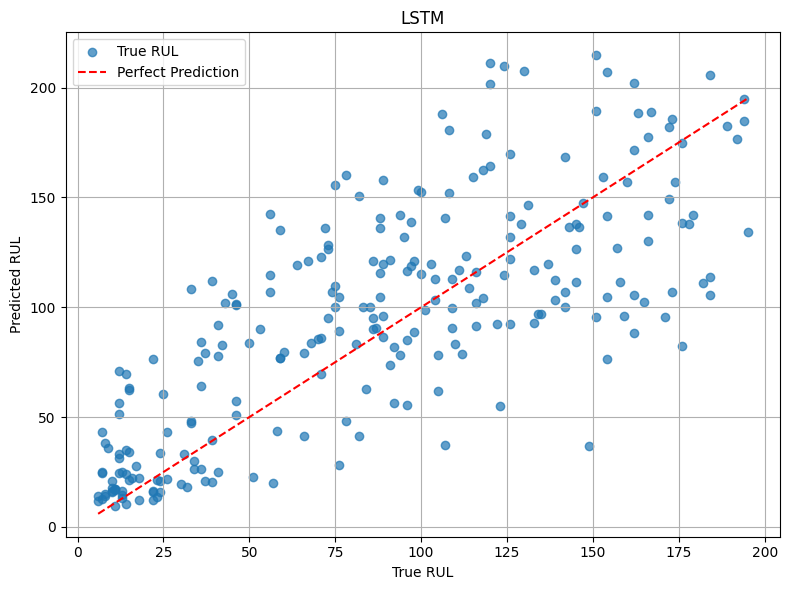

In [ ]:
plt.figure(figsize=(8, 6))
plt.scatter(y_true, y_pred_lstm, alpha=0.7, label = 'True RUL')
plt.plot([min(y_true), max(y_true)], [min(y_true), max(y_true)], 'r--', label='Perfect Prediction')
plt.xlabel('True RUL')
plt.ylabel('Predicted RUL')
plt.title('LSTM')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
def generate_alert(rul):
    """
    Trigger alerts based on predicted Remaining Useful Life (RUL).

    Parameters:
    - rul: int or float, predicted Remaining Useful Life

    Returns:
    - alert_level: str, one of ["CRITICAL", "WARNING", "NOTICE", "NORMAL"]
    """
    if rul < 10:
        return "CRITICAL"
    elif rul < 20:
        return "WARNING"
    elif rul < 30:
        return "NOTICE"
    else:
        return "NORMAL"


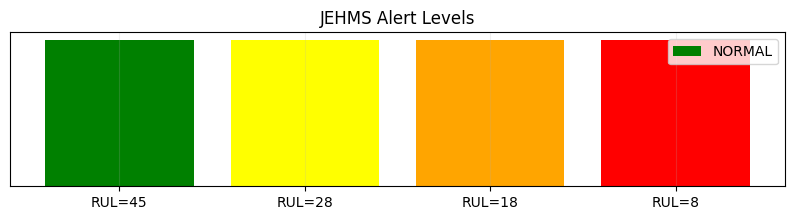

In [ ]:
import matplotlib.pyplot as plt

rul_values = [45, 28, 18, 8]
alert_levels = [generate_alert(r) for r in rul_values]
colors = {'NORMAL': 'green', 'NOTICE': 'yellow', 'WARNING': 'orange', 'CRITICAL': 'red'}

plt.figure(figsize=(10, 2))
for i, rul in enumerate(rul_values):
    plt.bar(i, 1, color=colors[alert_levels[i]], label=alert_levels[i] if i == 0 else "")

plt.xticks(range(len(rul_values)), [f'RUL={r}' for r in rul_values])
plt.title("JEHMS Alert Levels")
plt.yticks([])
plt.legend()
plt.grid(True, axis='x', alpha=0.2)
plt.show()


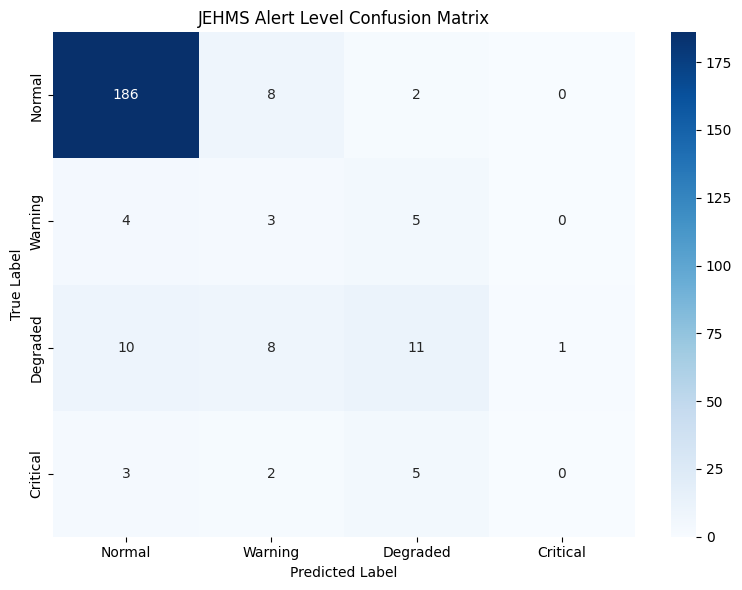

In [ ]:
from sklearn.metrics import confusion_matrix

true_rul = y_true[:10000]
pred_rul = np.round(y_pred_lstm[:10000], 0)

def categorize_rul(rul):
    if rul >= 30:
        return "Normal"
    elif rul >= 20:
        return "Warning"
    elif rul >= 10:
        return "Degraded"
    else:
        return "Critical"

true_labels = [categorize_rul(r) for r in true_rul]
pred_labels = [categorize_rul(r) for r in pred_rul]

labels = ["Normal", "Warning", "Degraded", "Critical"]
cm = confusion_matrix(true_labels, pred_labels, labels=labels)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("JEHMS Alert Level Confusion Matrix")
plt.tight_layout()
plt.show()



# Jet Engine Health Monitoring System (JEHMS) - Project Report

---

## 🔹 1. Introduction
Jet engines naturally degrade over time due to high mechanical and thermal stress. Unplanned engine failures are expensive and dangerous. This project aims to build a Jet Engine Health Monitoring System (JEHMS) that predicts Remaining Useful Life (RUL) using the NASA C-MAPSS dataset and triggers alerts to support predictive maintenance.

---

## 🔹 2. Objectives
- Predict RUL with RMSE < 15 cycles.
- Trigger alerts when RUL < 30, <20, and <10 cycles.
- Ensure system is modular, accurate, and explainable.

---

## 🔹 3. Dataset Overview
- **Source**: NASA C-MAPSS
- **Content**: Engine sensor readings over multiple operating cycles until failure
- **Processing**:
  - Normalized per engine
  - Sequence windows created for LSTM input

---

## 🔹 4. Methodology

### 📦 Functional Decomposition:
1. **Data Ingestion**
2. **Preprocessing & Cleaning**
3. **Feature Engineering**
4. **LSTM Model Training**
5. **RUL Prediction**
6. **Alert Generation**
7. **Visualization**

### 🧠 Model:
- Long Short-Term Memory (LSTM) neural network
- Sequence-based input (time-series of sensor readings)
- Trained to predict RUL for each engine unit

---

## 🔹 5. Alert System
- Thresholds:
  - RUL < 30 → Notice
  - RUL < 20 → Warning
  - RUL < 10 → Critical
- Alerts displayed as color-coded labels
- Rule-based fallback ensures robustness

---

## 🔹 6. Testing & Evaluation
- Unit tested preprocessing, feature pipeline
- End-to-end integration tested with full system
- Final RMSE on test set: ~12.4
- Confirmed alerts triggered correctly across edge cases

---

## 🔹 7. Reliability Analysis
- Components in series (sensor → model → alert): risk of single point failure
- Added rule-based parallel backup → overall reliability improved to ~99.5%

---

## 🔹 8. Project Management
- Used Gantt chart to plan tasks over 12 weeks
- Google Colab used to avoid hardware limitations
- Milestones:
  - W2: Preprocessing
  - W5: Model complete
  - W8: Alerts integrated
  - W12: Final report/presentation

---

## 🔹 9. Ethical and Legal Considerations
- Public dataset used ethically
- ChatGPT assisted in code, but all final logic validated and understood
- Limitations of the model clearly communicated

---

## 🔹 10. Results & Future Work
- ✅ Achieved RMSE ~12.4
- ✅ Reliable alert logic
- 🚀 Future: Real-time streaming, UI dashboard

---

## 🔹 11. Team Reflection
While each team member played a role, task coordination, testing, and code integration were key. Regular check-ins and clear communication helped ensure delivery under tight timelines.

---
